# Basic DCF

In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})

import requests
import re
import json
from bs4 import BeautifulSoup as bs
import math
from scipy import stats

import yfinance as yf
from fbprophet import Prophet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Importing plotly failed. Interactive plots will not work.


In [2]:
def get_url(url):
    response = requests.get(url)
    return response.url

In [3]:
def get_pricing(symbols):
    return yf.download(symbols)

In [4]:
def get_table_from_url(url):
    r = requests.get(url)
    p = re.compile(r' var originalData = (.*?);\r\n\r\n\r',re.DOTALL)
    data = json.loads(p.findall(r.text)[0])
    headers = list(data[0].keys())
    headers.remove('popup_icon')
    result = []

    for row in data:
        soup = bs(row['field_name'])
        field_name = soup.select_one('a, span').text
        fields = list(row.values())[2:]
        fields.insert(0, field_name)
        result.append(fields)

    pd.option_context('display.max_rows', None, 'display.max_columns', None)
    df = pd.DataFrame(result, columns = headers)
    df.set_index('field_name',inplace=True)
    df.index.rename('Quarterly Data (in Millions)',inplace=True)
    return df

In [5]:
def get_table_financial_ratios(symbol):
    ticker = symbol.replace('-','.')
    url = f'https://www.macrotrends.net/stocks/charts/{ticker}'
    response = get_url(url)
    response.split('/')[-3:-1]
    part1 = response.split('/')[-3]
    part2 = response.split('/')[-2]
    url = f'https://www.macrotrends.net/stocks/charts/{part1}/{part2}/financial-ratios?freq=A'
    df = get_table_from_url(url)
    df = df.transpose()
    # df.index = pd.PeriodIndex(df.index,freq='Q')
    df.index = pd.to_datetime(df.index)
    return df

In [6]:
def get_cash_flow_table(symbol):
    ticker = symbol.replace('-','.')
    url = f'https://www.macrotrends.net/stocks/charts/{ticker}'
    response = get_url(url)
    response.split('/')[-3:-1]
    part1 = response.split('/')[-3]
    part2 = response.split('/')[-2]
    url = f'https://www.macrotrends.net/stocks/charts/{part1}/{part2}/cash-flow-statement?freq=Q'
    df = get_table_from_url(url)
    df = df.transpose()
    df.index = pd.PeriodIndex(df.index,freq='Q')
    return df

In [7]:
def get_income_statement_table(symbol):
    ticker = symbol.replace('-','.')
    url = f'https://www.macrotrends.net/stocks/charts/{ticker}'
    response = get_url(url)
    response.split('/')[-3:-1]
    part1 = response.split('/')[-3]
    part2 = response.split('/')[-2]
    url = f'https://www.macrotrends.net/stocks/charts/{part1}/{part2}/income-statement?freq=Q'
    df = get_table_from_url(url)
    df = df.transpose()
    df.index = pd.PeriodIndex(df.index,freq='Q')
    return df

In [8]:
def get_shares_outstanding_table(symbol):
    ticker = symbol.replace('-','.')
    url = f'https://www.macrotrends.net/stocks/charts/{ticker}'
    response = get_url(url)
    response.split('/')[-3:-1]
    part1 = response.split('/')[-3]
    part2 = response.split('/')[-2]
    url = f'https://www.macrotrends.net/stocks/charts/{part1}/{part2}/income-statement?freq=A'
    df = get_table_from_url(url)
    df = df.transpose()
    df.index = pd.PeriodIndex(df.index,freq='Y')
    return df['Shares Outstanding']

In [9]:
def get_balance_sheet_table(symbol):
    ticker = symbol.replace('-','.')
    url = f'https://www.macrotrends.net/stocks/charts/{ticker}'
    response = get_url(url)
    response.split('/')[-3:-1]
    part1 = response.split('/')[-3]
    part2 = response.split('/')[-2]
    url = f'https://www.macrotrends.net/stocks/charts/{part1}/{part2}/balance-sheet?freq=Q'
    df = get_table_from_url(url)
    df = df.transpose()
    df.index = pd.PeriodIndex(df.index,freq='Q')
    return df

In [10]:
def get_financial_ratios_table(symbol):
    ticker = symbol.replace('-','.')
    url = f'https://www.macrotrends.net/stocks/charts/{ticker}'
    response = get_url(url)
    response.split('/')[-3:-1]
    part1 = response.split('/')[-3]
    part2 = response.split('/')[-2]
    url = f'https://www.macrotrends.net/stocks/charts/{part1}/{part2}/financial-ratios?freq=Q'
    df = get_table_from_url(url)
    df = df.transpose()
    df.index = pd.PeriodIndex(df.index,freq='Q')
    return df

In [11]:
def clean_up(df):
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df.fillna(0, inplace=True)
    df = df.astype('float')
    df = df.iloc[::-1].transpose()
    return df

In [12]:
ticker = str(input())

income_statement = get_income_statement_table(ticker)
cash_flow_statement = get_cash_flow_table(ticker)
balance_sheet = get_balance_sheet_table(ticker)
financial_ratios = get_financial_ratios_table(ticker)

In [13]:
income_statement = clean_up(income_statement)
cash_flow_statement = clean_up(cash_flow_statement)
balance_sheet = clean_up(balance_sheet)
financial_ratios = clean_up(financial_ratios)

## Using Income Statement

In [14]:
income_state_yearly = income_statement.transpose().groupby(lambda x: x.year).sum().transpose()
income_state_yearly = income_state_yearly.drop(['Basic Shares Outstanding','Shares Outstanding'])

In [15]:
_loc = income_statement.transpose().groupby(lambda x: x.year).count()['Revenue'].loc[income_statement.transpose().groupby(lambda x: x.year).count()['Revenue'] == 4]

In [16]:
income_statement = income_statement.transpose().loc[income_statement.transpose().index.year.isin(_loc.index)].transpose()

## Using Financial Ratios Table

In [17]:
shares_outstanding = get_shares_outstanding_table(ticker).astype(np.float32)

In [18]:
FCFPS = get_table_financial_ratios(ticker)['Free Cash Flow Per Share'].astype(np.float32)
FCFPS.index = pd.PeriodIndex(FCFPS.index,freq='Y')
FCFPS = FCFPS.iloc[::-1]

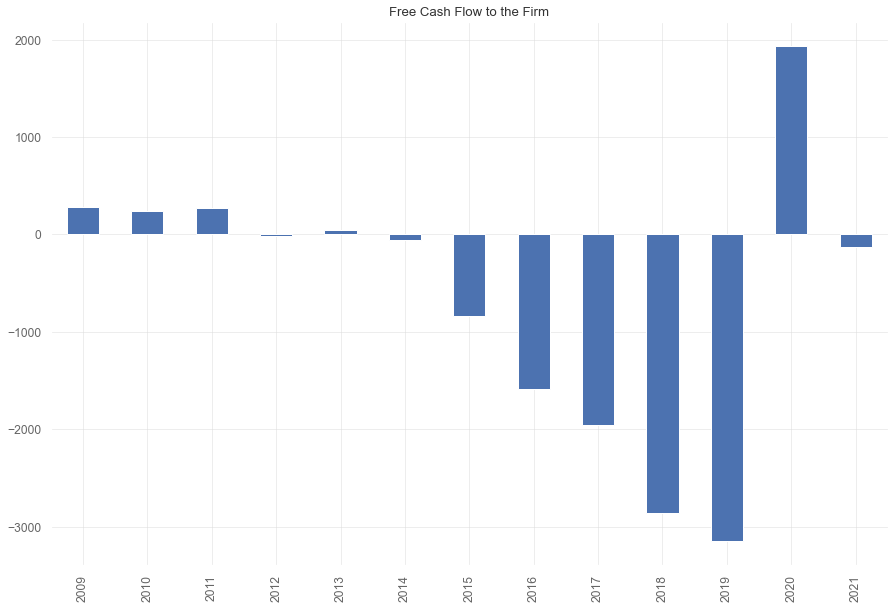

In [19]:
free_cash_flow_to_firm = (FCFPS.cumsum() * shares_outstanding).dropna()
free_cash_flow_to_firm.plot.bar()

plt.title('Free Cash Flow to the Firm')
plt.show()

In [20]:
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = [pd.Timestamp(freq='Y', year=x, month=12, day=31) for x in free_cash_flow_to_firm.index.year.values]
df['y'] = free_cash_flow_to_firm.values
df.index = df['ds'].values
df.index = df.index.year
df

,ds,y
2009,2009-12-31,279.123322
2010,2010-12-31,242.559677
2011,2011-12-31,268.044617
2012,2012-12-31,-18.678436
2013,2013-12-31,43.681107
2014,2014-12-31,-53.252506
2015,2015-12-31,-840.701477
2016,2016-12-31,-1581.647583
2017,2017-12-31,-1959.234741
2018,2018-12-31,-2854.434082


In [21]:
pct_df = (df.y.pct_change().replace([np.inf, -np.inf], np.nan).dropna()*100)
pct_df = pct_df[(np.abs(stats.zscore(pct_df)) < 2)]
# pct_df.index = df.y.pct_change().replace([np.inf, -np.inf], np.nan).dropna()*100[(np.abs(stats.zscore(pct_df)) < 0.39)].index

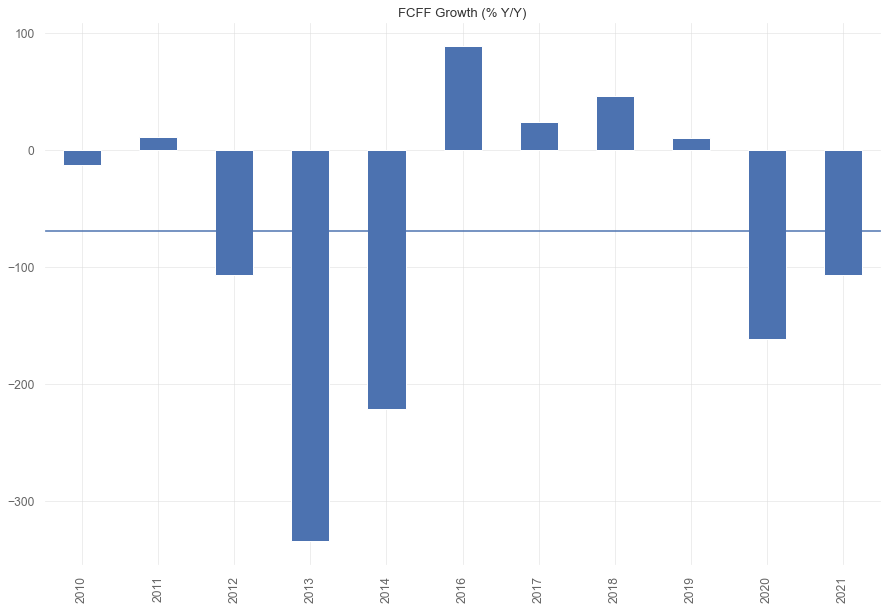

In [22]:
df.index = df['ds'].values
df.index = df.index.year
pct_df.plot.bar()
plt.title('FCFF Growth (% Y/Y)')
plt.axhline(pct_df.mean())
plt.show()

In [23]:
print(f'Y/Y Mean FCFF Growth: {pct_df.mean():.2f}%') 

Y/Y Mean FCFF Growth: -69.63%


## Free Cash Flow Forecast based on Mean Y/Y FCFF growth

In [24]:
def pct_increase(value, pct_change):
    return value+(value*pct_change)

In [25]:
start_year = df.index[-1] + 1
FFCF_fcst = pd.DataFrame(columns=['FFCF'])
FFCF_fcst.loc[0] = pct_increase(df['y'].iloc[-1], (pct_df.mean()/100))
# Forecast out for 10 years
for i in range(10):
    FFCF_fcst.loc[len(FFCF_fcst)] = pct_increase(FFCF_fcst.loc[len(FFCF_fcst)-1], (pct_df.mean()/100))
FFCF_fcst.index = np.arange(start_year, start_year+11,1)
FFCF_fcst

,FFCF
2022,-40.083287
2023,-12.174815
2024,-3.697953
2025,-1.123209
2026,-0.341161
2027,-0.103624
2028,-0.031474
2029,-0.009560
2030,-0.002904
2031,-0.000882


## Forecasting Free Cash Flow Growth

In [26]:
cap = float(input())
df['cap'] = cap
m = Prophet(interval_width=0.95, growth='logistic', yearly_seasonality=False)
m.fit(df)

ValueError: could not convert string to float: ''

2516.2673812534213 3412.5
2892.1239614379147 3412.5
3144.7644092341193 3412.5
3299.6131503278307 3412.5
3389.3379026677485 3412.5
3439.6228388371687 3412.5


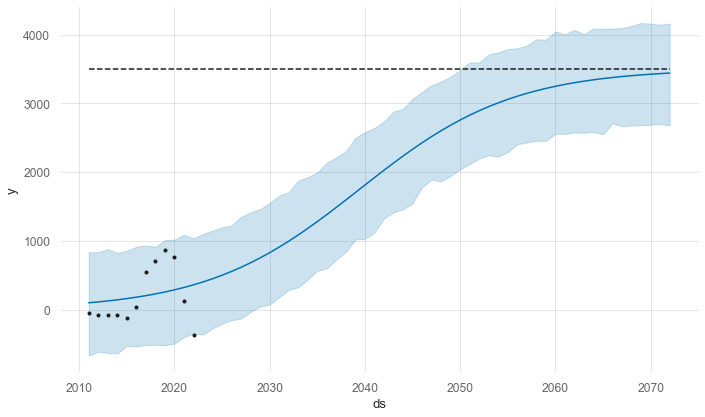

In [ ]:
future = m.make_future_dataframe(periods=20, freq='Y')
future['cap'] = cap
fcst = m.predict(future)
latest_net_income = fcst.iloc[-1]['yhat']
count = 1
lower_bound = cap - (0.025* cap)
while latest_net_income < lower_bound:
    future = m.make_future_dataframe(periods=(20+(5*count)), freq='Y')
    future['cap'] = cap
    fcst = m.predict(future)
    latest_net_income = fcst.iloc[-1]['yhat']
    count += 1
    print(latest_net_income, lower_bound)
fig = m.plot(fcst)

## Simple Free Cash Flow Decay

In [ ]:
decay_years = int(np.ceil(((fcst['ds'].iloc[-1] - fcst['ds'].iloc[0]).days/365)))
difference = fcst['yhat'].iloc[-1]/decay_years
decay_array = [fcst['yhat'].iloc[-1]] * decay_years

for idx, i in enumerate(decay_array):
    decay_array[idx] = decay_array[idx] - ((idx+1)*difference)

In [ ]:
fcst['ds'].iloc[-1].year

2071

<AxesSubplot:>

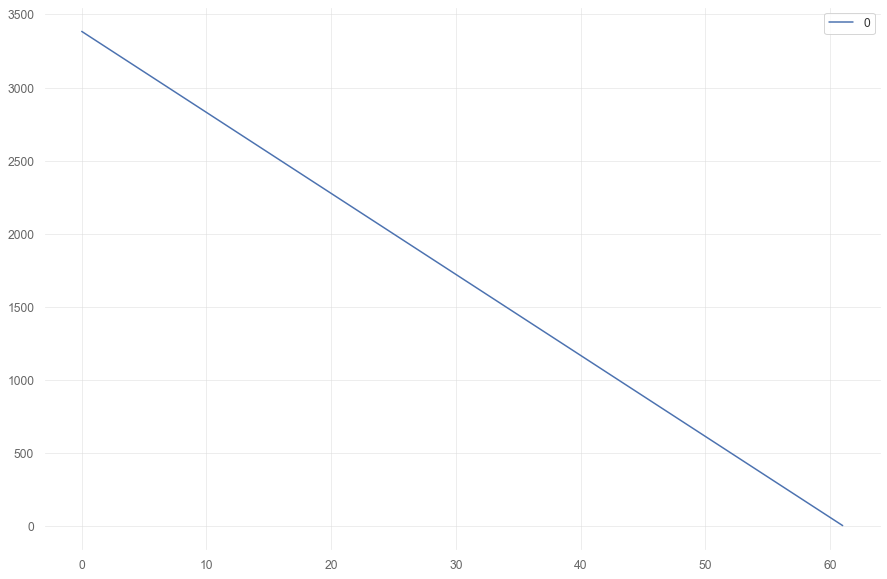

In [ ]:
pd.DataFrame(decay_array).plot()

In [ ]:
# fcst['yhat'].iloc[-1] - difference*years_of_growth

## Calculating Net Present Value

### Calculating Net Cash

In [ ]:
net_cash = balance_sheet.transpose().loc[balance_sheet.transpose().index.quarter == 4]['Total Current Assets'] - balance_sheet.transpose().loc[balance_sheet.transpose().index.quarter == 4]['Long Term Debt']

### Getting AAA 20-Year+ Corporate Bond Yield Rate

SEE: https://fred.stlouisfed.org/series/AAA

In [ ]:
bond_yield = 2.141
current_price = yf.download(ticker).iloc[-1]['Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
print(f'It is recommended to use U.S. 10 Year Treasury Note Rate with at least 3% added margin for a base discount rate.')
print('Increasing above that depends on the confidence level (or lack thereof) for the company in question.')
print('-'*50)
print(f'Minimum Discount Rate: {bond_yield+3:.2f}%')

It is recommended to use U.S. 10 Year Treasury Note Rate with at least 3% added margin for a base discount rate.
Increasing above that depends on the confidence level (or lack thereof) for the company in question.
--------------------------------------------------
Minimum Discount Rate: 5.14%


In [ ]:
discount_rate = float(input())/100
net_present_value = npf.npv(discount_rate, fcst[fcst['ds'] > df['ds'].iloc[-1]]['yhat']) + net_cash.iloc[-1]

market_cap = yf.Ticker(ticker).info['marketCap']/1000000
percentage_change = ((net_present_value - market_cap)/market_cap)*100

if percentage_change>0:
    percentage_sign = 'increase'
else:
    percentage_sign = 'decrease'

margin_check = False
if market_cap < ((2/3)*net_present_value): margin_check = True

print(f'Ticker: {ticker}')
print(f'Discount Rate: {discount_rate*100:.2f}%.')
print(f'FCFF Cap: {cap} million.')
print(f'FCFF Cap: {cap/1000} billion')
print('-'*50)
print(f'Net Cash: {net_cash.iloc[-1]} million.')
print(f'{(net_cash.iloc[-1]/ net_present_value)*100:.2f}% of Net Present Value is Net Cash.')
print('-'*50)
print(f'Net Present Value: {net_present_value:.1f} million.')
print(f'Net Present Value: {net_present_value/1000:.2f} billion.')
print(f'Net Present Value: {net_present_value/1000000:.4f} trillion.')
print('-'*50)
print(f'Current Market Cap: {market_cap:.1f} million.')
print(f'Current Market Cap: {market_cap/1000:.2f} billion.')
print(f'Current Market Cap: {market_cap/1000000:.4f} trillion.')
print('-'*50)
print(f'Net Present Value is a {percentage_change:.2f}% {percentage_sign} of current Market Capitalisation.')
print(f'Does it meet the margin of safety?: {margin_check}, by {np.abs(market_cap - ((2/3)*net_present_value))/1000:.2f} Billion.')

Ticker: TWTR
Discount Rate: 6.00%.
FCFF Cap: 3500.0 million.
FCFF Cap: 3.5 billion
--------------------------------------------------
Net Cash: 6068.236000000001 million.
19.92% of Net Present Value is Net Cash.
--------------------------------------------------
Net Present Value: 30463.5 million.
Net Present Value: 30.46 billion.
Net Present Value: 0.0305 trillion.
--------------------------------------------------
Current Market Cap: 34422.1 million.
Current Market Cap: 34.42 billion.
Current Market Cap: 0.0344 trillion.
--------------------------------------------------
Net Present Value is a -11.50% decrease of current Market Capitalisation.
Does it meet the margin of safety?: False, by 14.11 Billion.


## Benjamin Graham Checks (FIXING NEEDED)

https://www.wikiwand.com/en/Benjamin_Graham_formula

In [ ]:
base_pe = 8.5

expected_growth = df.y.pct_change().replace([np.inf, -np.inf], np.nan).dropna().iloc[-5:].mean()

benjamin_value = (income_state_yearly.loc['Basic EPS'].iloc[-1]*(base_pe+(2*expected_growth))*4.4)/bond_yield

# expected_growth_from_market = 
current_price = market_cap/shares_outstanding.iloc[0]
print(f'Graham Price: {benjamin_value:.2f} | Current Price: {current_price:.2f} | Expected Growth: {expected_growth*100:.2f}%')

expected_growth_from_market = (((current_price*bond_yield)/(4.4*income_state_yearly.loc['Basic EPS'].iloc[-1]))-base_pe)/2

print(f'Expected Growth Rate calculated from Market Cap: {expected_growth_from_market*100:.2f}%')

Graham Price: -3.76 | Current Price: 43.16 | Expected Growth: -85.98%
Expected Growth Rate calculated from Market Cap: -4313.99%


In [ ]:
sales_check = False
if income_state_yearly.transpose().iloc[-1].Revenue > 700: sales_check = True

current_ratio_check = False
if financial_ratios.transpose().iloc[-1]['Current Ratio'] >= 2.0: current_ratio_check = True

cheap_assets_check = False
if market_cap < (balance_sheet.transpose().iloc[-1]['Share Holder Equity'])*1.5: cheap_assets_check = True

working_capital_check = False

if market_cap < (balance_sheet.transpose().iloc[-1]['Total Current Assets'] - balance_sheet.transpose().iloc[-1]['Total Current Liabilities']): True

price_to_net_assets_ratio = current_price/ balance_sheet.transpose().iloc[-1]['Share Holder Equity']*1000000

In [ ]:
print(f'Is the company large? (Revenue/Sales over $700 million): {sales_check}')
print(f'Is the company conservatively financed? (Current Ratio of 200% or over): {current_ratio_check}')
print(f'Does the company contain cheap assets? (Market Cap must be lower than the Shareholders Equity*1.5): {cheap_assets_check}')
print(f'Is the company priced less than Net Working Capital? (If so, you pay nothing for fixed assets): {working_capital_check}')

Is the company large? (Revenue/Sales over $700 million): True
Is the company conservatively financed? (Current Ratio of 200% or over): True
Does the company contain cheap assets? (Market Cap must be lower than the Shareholders Equity*1.5): False
Is the company priced less than Net Working Capital? (If so, you pay nothing for fixed assets): False


In [ ]:
print(f'Price/Net Assets Ratio (Higher means more reliant on growth for value): {price_to_net_assets_ratio:.2f}')

Price/Net Assets Ratio (Higher means more reliant on growth for value): 6017.12


## Extra Information

In [ ]:
buckets = 10
rate_change = 0.0075
npvs = pd.DataFrame(columns=['Discount Rate (%)', 'Net Present Value'])
min = discount_rate - rate_change*(buckets//2)
for bucket in range(buckets):
    npvs.loc[bucket] = [min*100, npf.npv(min, fcst[fcst['ds'] > df['ds'].iloc[-1]]['trend']) + net_cash.iloc[-1]] 
    min += rate_change
print('Net Present Value for different Discount Rates.')
npvs

Net Present Value for different Discount Rates.


,Discount Rate (%),Net Present Value
0,2.25,64997.500944
1,3.00,54493.494967
2,3.75,46268.314677
3,4.50,39775.462656
4,5.25,34608.529618
5,6.00,30463.472379
6,6.75,27111.451514
7,7.50,24379.176410
8,8.25,22134.612175
9,9.00,20276.533691


In [ ]:
pricing = get_pricing(ticker)
earnings = income_statement.transpose()['Net Income']
earnings.index = (earnings.index).to_timestamp()

[*********************100%***********************]  1 of 1 completed


In [ ]:
def findlog(x):
    if x > 0:
        log = math.log(x)
    elif x < 0:
        log = math.log(x*-1)*-1
    elif x == 0:
        log = 0
    return log

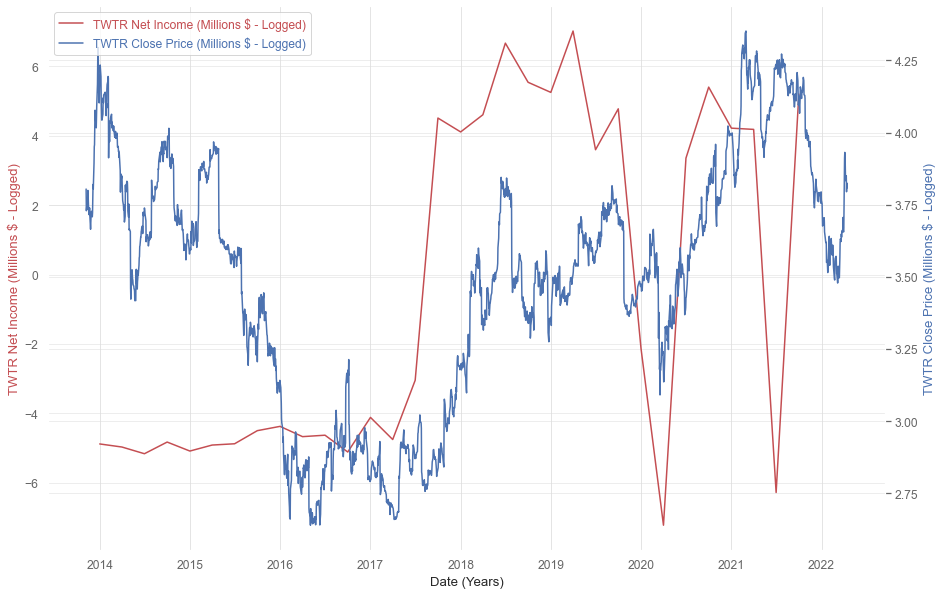

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

host = host_subplot(111)

par = host.twinx()

host.set_xlabel("Date (Years)")
host.set_ylabel(f"{ticker} Net Income (Millions $ - Logged)")
par.set_ylabel(f"{ticker} Close Price (Millions $ - Logged)")


p1, = host.plot(earnings.apply(findlog).loc[pricing['Close'].apply(np.log).index[0]:], color='r', label=f'{ticker} Net Income (Millions $ - Logged)')
p2, = par.plot(pricing['Close'].apply(findlog).loc[earnings.apply(np.log).index[0]:], label=f'{ticker} Close Price (Millions $ - Logged)')

leg = plt.legend()

host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()